# Lab 2: CNN

Creating our model layers and our optimiser class.

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Dict, List
import time

class AdamOptimizer:
    def __init__(self, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}  # First moment
        self.v = {}  # Second moment
        self.t = 0   # Timestep
        
    def initialize(self, layer_name, W, b):
        """Initialize moment vectors for a layer's parameters"""
        if layer_name not in self.m:
            self.m[layer_name] = {
                'W': np.zeros_like(W),
                'b': np.zeros_like(b)
            }
            self.v[layer_name] = {
                'W': np.zeros_like(W),
                'b': np.zeros_like(b)
            }
            
    def update(self, layer_name, layer, learning_rate):
        """Update parameters using Adam optimization"""
        if layer_name not in self.m:
            self.initialize(layer_name, layer.W, layer.b)
            
        self.t += 1
        
        # Update weights
        self.m[layer_name]['W'] = self.beta1 * self.m[layer_name]['W'] + (1 - self.beta1) * layer.dW
        self.v[layer_name]['W'] = self.beta2 * self.v[layer_name]['W'] + (1 - self.beta2) * np.square(layer.dW)
        
        m_hat = self.m[layer_name]['W'] / (1 - self.beta1**self.t)
        v_hat = self.v[layer_name]['W'] / (1 - self.beta2**self.t)
        
        layer.W -= learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        
        # Update biases
        self.m[layer_name]['b'] = self.beta1 * self.m[layer_name]['b'] + (1 - self.beta1) * layer.db
        self.v[layer_name]['b'] = self.beta2 * self.v[layer_name]['b'] + (1 - self.beta2) * np.square(layer.db)
        
        m_hat = self.m[layer_name]['b'] / (1 - self.beta1**self.t)
        v_hat = self.v[layer_name]['b'] / (1 - self.beta2**self.t)
        
        layer.b -= learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # Initialize weights and biases
        self.W = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * np.sqrt(2.0 / (in_channels * kernel_size * kernel_size))
        self.b = np.zeros((out_channels, 1))
        
        # Gradients
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
        # Cache for backward pass
        self.cache = None
        
    def forward(self, X):
        n_samples, c, h, w = X.shape
        h_out = (h + 2*self.padding - self.kernel_size) // self.stride + 1
        w_out = (w + 2*self.padding - self.kernel_size) // self.stride + 1
        
        if self.padding > 0:
            X_padded = np.pad(X, ((0,0), (0,0), (self.padding,self.padding), (self.padding,self.padding)), 
                            mode='constant')
        else:
            X_padded = X
        
        output = np.zeros((n_samples, self.out_channels, h_out, w_out))
        
        for i in range(h_out):
            for j in range(w_out):
                h_start = i * self.stride
                h_end = h_start + self.kernel_size
                w_start = j * self.stride
                w_end = w_start + self.kernel_size
                
                X_patch = X_padded[:, :, h_start:h_end, w_start:w_end]
                
                for k in range(self.out_channels):
                    output[:, k, i, j] = np.sum(X_patch * self.W[k, :, :, :], axis=(1,2,3)) + self.b[k]
        
        self.cache = (X, X_padded)
        return output
    
    def backward(self, dout):
        X, X_padded = self.cache
        n_samples, _, h_out, w_out = dout.shape
        
        # Initialize gradients
        dX_padded = np.zeros_like(X_padded)
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
        # Compute gradients
        for i in range(h_out):
            for j in range(w_out):
                h_start = i * self.stride
                h_end = h_start + self.kernel_size
                w_start = j * self.stride
                w_end = w_start + self.kernel_size
                
                for k in range(self.out_channels):
                    dX_padded[:, :, h_start:h_end, w_start:w_end] += \
                        self.W[k, :, :, :] * dout[:, k, i, j][:, None, None, None]
                    self.dW[k] += np.sum(
                        X_padded[:, :, h_start:h_end, w_start:w_end] * \
                        dout[:, k, i, j][:, None, None, None],
                        axis=0
                    )
                    self.db[k] += np.sum(dout[:, k, i, j])
        
        # Remove padding from dX if necessary
        if self.padding > 0:
            dX = dX_padded[:, :, self.padding:-self.padding, self.padding:-self.padding]
        else:
            dX = dX_padded
            
        return dX


class MaxPool2D:
    def __init__(self, kernel_size, stride=None):
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.cache = None
        
    def forward(self, X):
        n_samples, c, h, w = X.shape
        h_out = (h - self.kernel_size) // self.stride + 1
        w_out = (w - self.kernel_size) // self.stride + 1
        
        output = np.zeros((n_samples, c, h_out, w_out))
        self.cache = {}
        
        for i in range(h_out):
            for j in range(w_out):
                h_start = i * self.stride
                h_end = h_start + self.kernel_size
                w_start = j * self.stride
                w_end = w_start + self.kernel_size
                
                X_patch = X[:, :, h_start:h_end, w_start:w_end]
                output[:, :, i, j] = np.max(X_patch, axis=(2, 3))
                
                self.cache[(i, j)] = (X_patch, h_start, h_end, w_start, w_end)
        
        return output
    
    def backward(self, dout):
        n_samples, c, h_out, w_out = dout.shape
        h = h_out * self.stride
        w = w_out * self.stride
        
        dX = np.zeros((n_samples, c, h, w))
        
        for i in range(h_out):
            for j in range(w_out):
                X_patch, h_start, h_end, w_start, w_end = self.cache[(i, j)]
                
                # Create mask for max locations
                mask = (X_patch == np.max(X_patch, axis=(2, 3))[:, :, None, None])
                
                # Distribute gradient
                dX[:, :, h_start:h_end, w_start:w_end] += \
                    mask * dout[:, :, i, j][:, :, None, None]
        
        return dX

class FullyConnected:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.W = np.random.randn(output_size, input_size) * np.sqrt(2.0 / input_size)
        self.b = np.zeros((output_size, 1))
        self.cache = None
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, X):
        batch_size = X.shape[0]
        # Reshape input to (batch_size, input_size)
        X_reshaped = X.reshape(batch_size, -1)
        
        if X_reshaped.shape[1] != self.input_size:
            raise ValueError(f"Input size mismatch. Expected {self.input_size}, got {X_reshaped.shape[1]}")
            
        self.cache = X_reshaped
        return np.dot(X_reshaped, self.W.T) + self.b.T
    
    def backward(self, dout):
        X = self.cache
        
        self.dW = np.dot(dout.T, X)
        self.db = np.sum(dout, axis=0).reshape(-1, 1)
        
        dX = np.dot(dout, self.W)
        return dX.reshape(X.shape[0], -1)

## Creating our model class

It will have two convolution layers, two MaxPooling layers and three Dense layers.

In [98]:
class LeNet5:
    def __init__(self):
        # For MNIST input size is 28x28
        self.conv1 = Conv2D(in_channels=1, out_channels=6, kernel_size=5)  # Output: 6x24x24
        self.pool1 = MaxPool2D(kernel_size=2, stride=2)  # Output: 6x12x12
        self.conv2 = Conv2D(in_channels=6, out_channels=16, kernel_size=5)  # Output: 16x8x8
        self.pool2 = MaxPool2D(kernel_size=2, stride=2)  # Output: 16x4x4
        
        # Calculate sizes for fully connected layers
        self.fc1 = FullyConnected(16*4*4, 120)  # First FC layer
        self.fc2 = FullyConnected(120, 84)      # Second FC layer
        self.fc3 = FullyConnected(84, 10)       # Output layer

        self.cache = []
        
    def forward(self, X):
        self.cache = []
        # Ensure input is float32
        X = X.astype(np.float32)
        
        # First conv + relu
        out = self.conv1.forward(X)
        self.cache.append(out)
        out = np.maximum(0, out)  # ReLU
        self.cache.append(out)
        
        # First pooling
        out = self.pool1.forward(out)
        self.cache.append(out)
        
        # Second conv + relu
        out = self.conv2.forward(out)
        self.cache.append(out)
        out = np.maximum(0, out)  # ReLU
        self.cache.append(out)
        
        # Second pooling
        out = self.pool2.forward(out)
        self.cache.append(out)
        
        # Fully connected layers
        out = self.fc1.forward(out)
        self.cache.append(out)
        out = np.maximum(0, out)  # ReLU
        self.cache.append(out)
        
        out = self.fc2.forward(out)
        self.cache.append(out)
        out = np.maximum(0, out)  # ReLU
        self.cache.append(out)
        
        out = self.fc3.forward(out)
        self.cache.append(out)
        return out
    
    def backward(self, dout):
        # Backward FC3
        dout = self.fc3.backward(dout)
        
        # Backward FC2 + ReLU
        dout = dout * (self.cache[-2] > 0)  # ReLU backward
        dout = self.fc2.backward(dout)
        
        # Backward FC1 + ReLU
        dout = dout * (self.cache[-4] > 0)  # ReLU backward
        dout = self.fc1.backward(dout)
        
        # Reshape back to conv dimensions
        dout = dout.reshape(self.cache[5].shape)
        
        # Backward Pool2
        dout = self.pool2.backward(dout)
        
        # Backward Conv2 + ReLU
        dout = dout * (self.cache[3] > 0)  # ReLU backward
        dout = self.conv2.backward(dout)
        
        # Backward Pool1
        dout = self.pool1.backward(dout)
        
        # Backward Conv1 + ReLU
        dout = dout * (self.cache[0] > 0)  # ReLU backward
        dout = self.conv1.backward(dout)
        
        return dout

Functions to help with importing the MNIST dataset and prepare it for training.

In [99]:
def prepare_mnist_data(x_train: np.ndarray, 
                      y_train: np.ndarray, 
                      x_test: np.ndarray, 
                      y_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Prepare MNIST data for training: normalize, reshape, etc.
    """
    # Ensure proper shapes
    if len(x_train.shape) == 3:
        x_train = np.expand_dims(x_train, axis=1)
    if len(x_test.shape) == 3:
        x_test = np.expand_dims(x_test, axis=1)
        
    # Convert to float32 and normalize
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0
    
    # Convert labels to integer type
    y_train = y_train.astype(np.int64)
    y_test = y_test.astype(np.int64)
    
    return x_train, y_train, x_test, y_test

def get_batches(x: np.ndarray, 
                y: np.ndarray, 
                batch_size: int, 
                shuffle: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate batches from data with optional shuffling
    """
    if shuffle:
        indices = np.random.permutation(len(x))
        x = x[indices]
        y = y[indices]
    
    for i in range(0, len(x), batch_size):
        yield x[i:i + batch_size], y[i:i + batch_size]

def compute_accuracy(model: LeNet5, 
                    x: np.ndarray, 
                    y: np.ndarray, 
                    batch_size: int = 32) -> float:
    """
    Compute accuracy over the given dataset
    """
    correct = 0
    total = 0
    
    for x_batch, y_batch in get_batches(x, y, batch_size, shuffle=False):
        outputs = model.forward(x_batch)
        predictions = np.argmax(outputs, axis=1)
        correct += np.sum(predictions == y_batch)
        total += len(y_batch)
    
    return correct / total

Training class to handle the batch processing and training. It includes all the necessary configurations for training.

In [100]:
class TrainingConfig:
    def __init__(self,
                 epochs: int = 10,
                 batch_size: int = 32,
                 learning_rate: float = 0.001,
                 learning_rate_decay: float = 0.95,
                 momentum: float = 0.9,
                 weight_decay: float = 0.0005,
                 validate_every: int = 1,
                 print_every: int = 100):
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.learning_rate_decay = learning_rate_decay
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.validate_every = validate_every
        self.print_every = print_every

class Trainer:
    def __init__(self, model: LeNet5, config: TrainingConfig):
        self.model = model
        self.config = config
        self.velocities = self._initialize_velocities()
        
    def _initialize_velocities(self) -> Dict:
        """Initialize momentum velocities for all parameters"""
        velocities = {}
        for name, layer in [('conv1', self.model.conv1), 
                          ('conv2', self.model.conv2),
                          ('fc1', self.model.fc1),
                          ('fc2', self.model.fc2),
                          ('fc3', self.model.fc3)]:
            velocities[f'{name}_W'] = np.zeros_like(layer.W)
            velocities[f'{name}_b'] = np.zeros_like(layer.b)
        return velocities
    
    def _update_parameters(self, learning_rate: float):
        """Update parameters using momentum and weight decay"""
        for name, layer in [('conv1', self.model.conv1), 
                          ('conv2', self.model.conv2),
                          ('fc1', self.model.fc1),
                          ('fc2', self.model.fc2),
                          ('fc3', self.model.fc3)]:
            # Add weight decay
            layer.dW += self.config.weight_decay * layer.W
            
            # Update velocities
            self.velocities[f'{name}_W'] = (self.config.momentum * self.velocities[f'{name}_W'] - 
                                          learning_rate * layer.dW)
            self.velocities[f'{name}_b'] = (self.config.momentum * self.velocities[f'{name}_b'] - 
                                          learning_rate * layer.db)
            
            # Update parameters
            layer.W += self.velocities[f'{name}_W']
            layer.b += self.velocities[f'{name}_b']
    
    def train_step(self, x_batch: np.ndarray, y_batch: np.ndarray, learning_rate: float) -> float:
        """Perform one training step"""
        batch_size = len(x_batch)
        
        # Forward pass
        logits = self.model.forward(x_batch)
        
        # Compute loss and gradients
        exp_scores = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        # Cross entropy loss
        correct_logprobs = -np.log(probs[range(batch_size), y_batch])
        loss = np.mean(correct_logprobs)
        
        # Compute gradients
        dscores = probs.copy()
        dscores[range(batch_size), y_batch] -= 1
        dscores /= batch_size
        
        # Backward pass
        self.model.backward(dscores)

        # Update parameters using Adam
        for layer_name, layer in [
            ('conv1', model.conv1),
            ('conv2', model.conv2),
            ('fc1', model.fc1),
            ('fc2', model.fc2),
            ('fc3', model.fc3)]:

            self.model.optimizer.update(layer_name, layer, learning_rate)
        
        # Update parameters
        self._update_parameters(learning_rate)
        
        return loss
    
    def train(self, 
              x_train: np.ndarray, 
              y_train: np.ndarray, 
              x_val: np.ndarray = None, 
              y_val: np.ndarray = None) -> Dict:
        """
        Train the model and return training history
        """
        history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'learning_rates': []
        }
        
        n_batches = len(x_train) // self.config.batch_size
        learning_rate = self.config.learning_rate
        
        print(f"Starting training for {self.config.epochs} epochs...")
        start_time = time.time()
        
        for epoch in range(self.config.epochs):
            epoch_loss = 0
            batch_count = 0
            
            # Training loop
            for x_batch, y_batch in get_batches(x_train, y_train, self.config.batch_size):
                loss = self.train_step(x_batch, y_batch, learning_rate)
                epoch_loss += loss
                batch_count += 1
                
                # Print progress
                if batch_count % self.config.print_every == 0:
                    print(f"Epoch {epoch+1}/{self.config.epochs}, "
                          f"Batch {batch_count}/{n_batches}, "
                          f"Loss: {loss:.4f}, "
                          f"LR: {learning_rate:.6f}")
            
            # Compute epoch metrics
            epoch_loss /= n_batches
            train_acc = compute_accuracy(self.model, x_train, y_train, self.config.batch_size)
            
            # Validation
            if x_val is not None and epoch % self.config.validate_every == 0:
                val_acc = compute_accuracy(self.model, x_val, y_val, self.config.batch_size)
                print(f"\nEpoch {epoch+1} - "
                      f"Loss: {epoch_loss:.4f}, "
                      f"Train Acc: {train_acc:.4f}, "
                      f"Val Acc: {val_acc:.4f}, "
                      f"LR: {learning_rate:.6f}")
                
                history['val_acc'].append(val_acc)
            else:
                print(f"\nEpoch {epoch+1} - "
                      f"Loss: {epoch_loss:.4f}, "
                      f"Train Acc: {train_acc:.4f}, "
                      f"LR: {learning_rate:.6f}")
            
            # Update learning rate
            learning_rate *= self.config.learning_rate_decay
            
            # Store metrics
            history['train_loss'].append(epoch_loss)
            history['train_acc'].append(train_acc)
            history['learning_rates'].append(learning_rate)
        
        training_time = time.time() - start_time
        print(f"\nTraining completed in {training_time:.2f} seconds")
        
        return history
    

Importing and preprocessing the dataset. It will be 30 - 70 split for training.

In [101]:
# Load MNIST data
from keras.datasets import mnist
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_full = np.concatenate([x_train,x_test])
y_full = np.concatenate([y_train,y_test])

x_train,x_test,y_train,y_test = train_test_split(x_full,y_full,test_size=0.3,random_state=42)



# Prepare data
x_train, y_train, x_test, y_test = prepare_mnist_data(x_train, y_train, x_test, y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)




(49000, 1, 28, 28)
(49000,)
(21000, 1, 28, 28)
(21000,)


Checking ballance between out target classes.

In [102]:
import pandas as pd

unique, counts = np.unique(y_train, return_counts=True)
df = pd.DataFrame(counts, columns=["Counts"])
df

,Counts
0,4845
1,5513
2,4857
3,4965
4,4888
5,4398
6,4788
7,5045
8,4833
9,4868


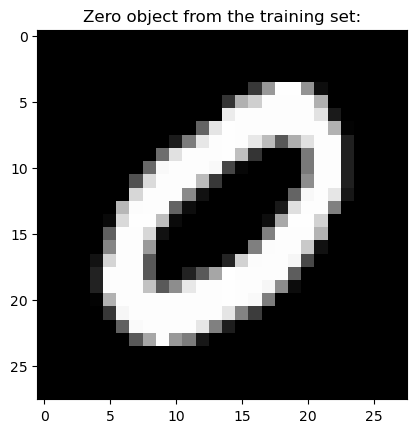

In [103]:
plt.title("Zero object from the training set:")
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")

## Training the model

In [104]:
# Create model and training config
model = LeNet5()
model.optimizer = AdamOptimizer()
config = TrainingConfig(
    epochs=5,
    batch_size=32,
    learning_rate=0.001,
    learning_rate_decay=0.95,
    momentum=0.9,
    weight_decay=0.0005,
    validate_every=1,
    print_every=100
)

# Create trainer and train
trainer = Trainer(model, config)
history = trainer.train(
    x_train=x_train, 
    y_train=y_train,
    x_val=x_test, 
    y_val=y_test
)


Starting training for 5 epochs...
Epoch 1/5, Batch 100/1531, Loss: 0.1917, LR: 0.001000
Epoch 1/5, Batch 200/1531, Loss: 0.1776, LR: 0.001000
Epoch 1/5, Batch 300/1531, Loss: 0.0412, LR: 0.001000
Epoch 1/5, Batch 400/1531, Loss: 0.0934, LR: 0.001000
Epoch 1/5, Batch 500/1531, Loss: 0.1159, LR: 0.001000
Epoch 1/5, Batch 600/1531, Loss: 0.0305, LR: 0.001000
Epoch 1/5, Batch 700/1531, Loss: 0.0781, LR: 0.001000
Epoch 1/5, Batch 800/1531, Loss: 0.1512, LR: 0.001000
Epoch 1/5, Batch 900/1531, Loss: 0.0584, LR: 0.001000
Epoch 1/5, Batch 1000/1531, Loss: 0.0816, LR: 0.001000
Epoch 1/5, Batch 1100/1531, Loss: 0.0563, LR: 0.001000
Epoch 1/5, Batch 1200/1531, Loss: 0.0873, LR: 0.001000
Epoch 1/5, Batch 1300/1531, Loss: 0.2817, LR: 0.001000
Epoch 1/5, Batch 1400/1531, Loss: 0.0814, LR: 0.001000
Epoch 1/5, Batch 1500/1531, Loss: 0.0451, LR: 0.001000

Epoch 1 - Loss: 0.1573, Train Acc: 0.9844, Val Acc: 0.9798, LR: 0.001000
Epoch 2/5, Batch 100/1531, Loss: 0.1219, LR: 0.000950
Epoch 2/5, Batch 200/1

Plotting the results of training. We plot Loss and Validation scores per epoch.

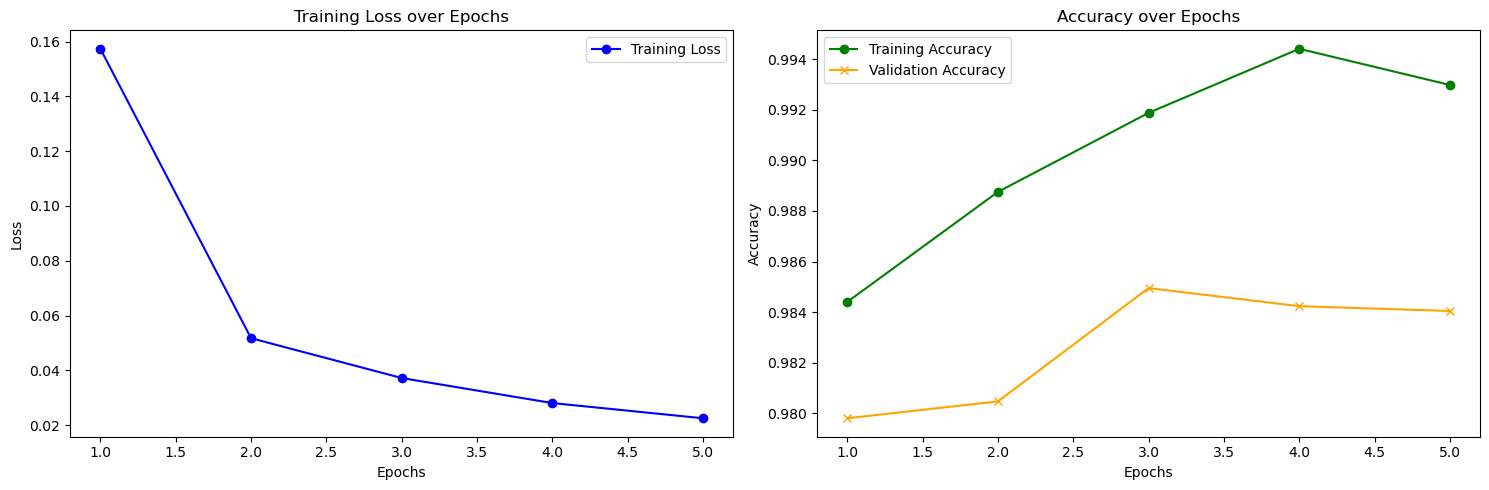

In [105]:
# Epochs (assuming 1-based index for epochs)
epochs = range(1, len(history['train_loss']) + 1)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Training Loss
axs[0].plot(epochs, history['train_loss'], label='Training Loss', marker='o', color='blue')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Training and Validation Accuracy
axs[1].plot(epochs, history['train_acc'], label='Training Accuracy', marker='o', color='green')
axs[1].plot(epochs, history['val_acc'], label='Validation Accuracy', marker='x', color='orange')
axs[1].set_title('Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()


# Display plots
plt.tight_layout()
plt.show()


Predicting on the test set for evaluation.

In [106]:
pred = model.forward(x_test)

One-hot-encoding the predictions.

In [107]:
from keras.utils import to_categorical

predictions = []
for i in range(len(pred)):
    one_hot_pred = np.zeros_like(pred[i])
    one_hot_pred[np.argmax(pred[i])] = 1
    predictions.append(one_hot_pred.flatten())

y_test = to_categorical(y_test)


## ROC Curves

Functions for plotting the ROC curve as well as to calculate metrics.

In [108]:
def calculate_roc_auc(y_true, y_scores, plot=True):
    # Sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_scores, kind="mergesort")[::-1]
    y_scores = y_scores[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # Calculate ROC curve points
    distinct_value_indices = np.where(np.diff(y_scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]
    
    tps = np.cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps
    
    tps = np.r_[0, tps]
    fps = np.r_[0, fps]
    
    # Calculate TPR and FPR
    n_pos = np.sum(y_true)
    n_neg = len(y_true) - n_pos
    
    fpr_array = fps / n_neg
    tpr_array = tps / n_pos
    
    # Calculate AUC using trapezoidal rule
    auc = np.trapz(tpr_array, fpr_array)
    
    if plot:
        plt.figure(figsize=(5, 5))
        plt.plot(fpr_array, tpr_array, 'b-', label=f'ROC curve (AUC = {auc:.3f})')
        plt.plot([0, 1], [0, 1], 'r--', label='Random classifier')
        plt.xlim([0, 1])
        plt.ylim([0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
    
    return auc, fpr_array, tpr_array

def calculate_roc_auc_multiclass(y_true, y_scores, plot=True):
    n_classes = y_true.shape[1]
    fpr_dict = {}
    tpr_dict = {}
    auc_scores = []
    
    if plot:
        plt.figure(figsize=(5, 5))
    
    for i in range(n_classes):
        auc, fpr, tpr = calculate_roc_auc(y_true[:, i], y_scores[:, i], plot=False)
        auc_scores.append(auc)
        fpr_dict[i] = fpr
        tpr_dict[i] = tpr
        
        if plot:
            plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.3f})')
    
    if plot:
        plt.plot([0, 1], [0, 1], 'r--', label='Random classifier')
        plt.xlim([0, 1])
        plt.ylim([0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves for Multi-class Classification')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()
    
    return np.array(auc_scores), fpr_dict, tpr_dict

def calculate_metrics(y_true, y_pred):
    # Convert inputs to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate confusion matrix elements
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': {
            'tp': tp, 'fp': fp,
            'tn': tn, 'fn': fn
        }
    }


Plotting multi-class ROC curve and General ROC curve

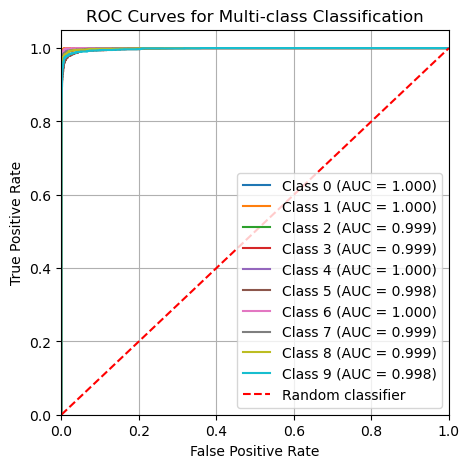

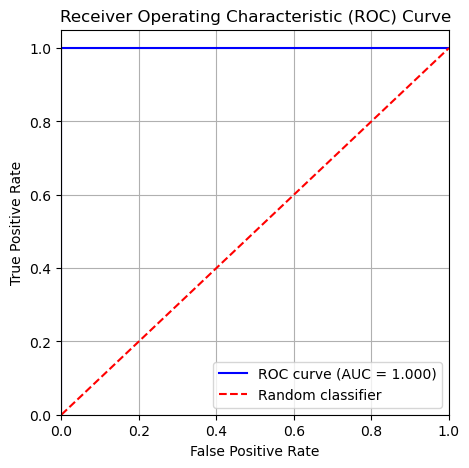

In [109]:
auc_scores, _, _ = calculate_roc_auc_multiclass(y_test, pred)

# Calculate metrics
metrics_binary = calculate_metrics(y_test, predictions)
auc_binary, _, _ = calculate_roc_auc(y_test[0], pred[0])
    

## Metrics

In [110]:
print("Binary Classification Metrics:")
print(f"Accuracy:  {metrics_binary['accuracy']:.3f}")
print(f"Precision: {metrics_binary['precision']:.3f}")
print(f"Recall:    {metrics_binary['recall']:.3f}")
print(f"F1 Score:  {metrics_binary['f1']:.3f}")
print(f"AUC Score: {auc_binary:.3f}")

Binary Classification Metrics:
Accuracy:  0.997
Precision: 0.984
Recall:    0.984
F1 Score:  0.984
AUC Score: 1.000


## Confussion Matrix

We plot a raw values confusion matrix and a normalised confusion matrix. They are both multi class.

Confusion Matrix (raw counts):


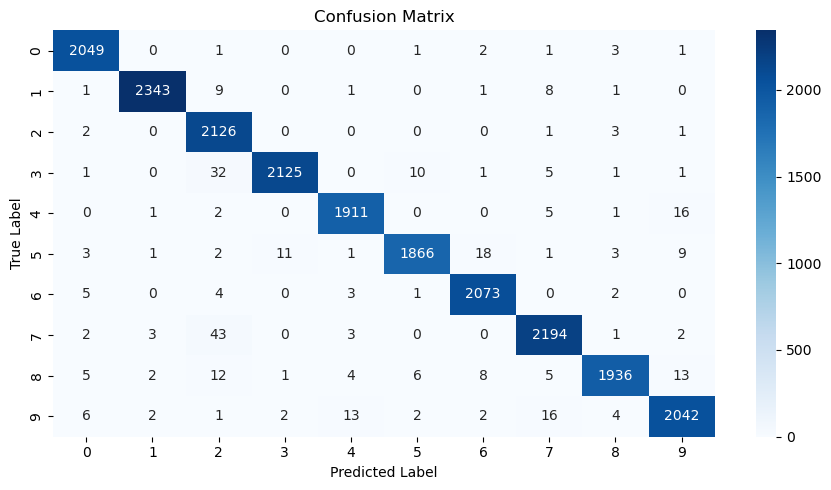


Confusion Matrix (normalized by true labels):


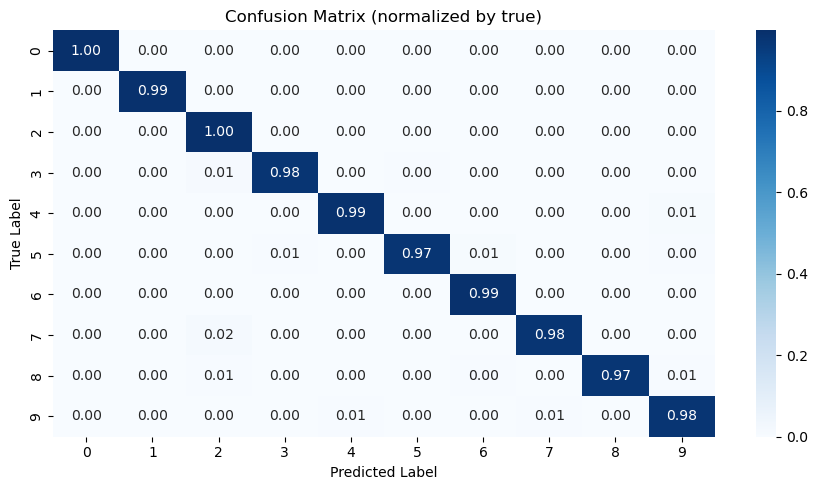


Detailed metrics per class:

Class 0:
Precision: 0.988
Recall: 0.996
F1 Score: 0.992
Accuracy: 0.998

Class 1:
Precision: 0.996
Recall: 0.991
F1 Score: 0.994
Accuracy: 0.999

Class 2:
Precision: 0.953
Recall: 0.997
F1 Score: 0.974
Accuracy: 0.995

Class 3:
Precision: 0.993
Recall: 0.977
F1 Score: 0.985
Accuracy: 0.997

Class 4:
Precision: 0.987
Recall: 0.987
F1 Score: 0.987
Accuracy: 0.998

Class 5:
Precision: 0.989
Recall: 0.974
F1 Score: 0.982
Accuracy: 0.997

Class 6:
Precision: 0.985
Recall: 0.993
F1 Score: 0.989
Accuracy: 0.998

Class 7:
Precision: 0.981
Recall: 0.976
F1 Score: 0.979
Accuracy: 0.995

Class 8:
Precision: 0.990
Recall: 0.972
F1 Score: 0.981
Accuracy: 0.996

Class 9:
Precision: 0.979
Recall: 0.977
F1 Score: 0.978
Accuracy: 0.996


In [111]:
import seaborn as sns

def create_confusion_matrix(y_true, y_pred, normalize=None):
    # Convert one-hot encoded to class indices if needed
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)
    if len(y_pred.shape) > 1:
        y_pred = np.argmax(y_pred, axis=1)
    
    # Get number of classes
    n_classes = max(np.max(y_true), np.max(y_pred)) + 1
    
    # Initialize confusion matrix
    conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
    
    # Fill confusion matrix
    for t, p in zip(y_true, y_pred):
        conf_matrix[t, p] += 1
    
    # Calculate per-class accuracies
    accuracy_per_class = {}
    for i in range(n_classes):
        true_positive = conf_matrix[i, i]
        total_samples = np.sum(conf_matrix[i, :])
        accuracy = true_positive / total_samples if total_samples > 0 else 0
        accuracy_per_class[i] = accuracy
    
    # Normalize if requested
    if normalize == 'true':
        conf_matrix = conf_matrix.astype(float)
        row_sums = conf_matrix.sum(axis=1)
        conf_matrix = np.divide(conf_matrix, row_sums[:, np.newaxis],
                              where=row_sums[:, np.newaxis] != 0)
    elif normalize == 'pred':
        conf_matrix = conf_matrix.astype(float)
        col_sums = conf_matrix.sum(axis=0)
        conf_matrix = np.divide(conf_matrix, col_sums[np.newaxis, :],
                              where=col_sums[np.newaxis, :] != 0)
    elif normalize == 'all':
        conf_matrix = conf_matrix.astype(float) / conf_matrix.sum()
    
    return conf_matrix, accuracy_per_class

def plot_confusion_matrix(conf_matrix, class_names=None, normalize=None, 
                         fig_size=(9, 5), cmap='Blues'):
    plt.figure(figsize=fig_size)
    
    # Create class names if not provided
    if class_names is None:
        class_names = [str(i) for i in range(len(conf_matrix))]
    
    # Create heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    
    # Add labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    title = 'Confusion Matrix'
    if normalize:
        title += f' (normalized by {normalize})'
    plt.title(title)
    
    plt.tight_layout()
    plt.show()

def analyze_confusion_matrix(conf_matrix, class_names=None):
    n_classes = len(conf_matrix)
    if class_names is None:
        class_names = [str(i) for i in range(n_classes)]
    
    metrics = {}
    
    for i in range(n_classes):
        # True Positives: diagonal elements
        tp = conf_matrix[i, i]
        
        # False Positives: sum of column minus diagonal element
        fp = np.sum(conf_matrix[:, i]) - tp
        
        # False Negatives: sum of row minus diagonal element
        fn = np.sum(conf_matrix[i, :]) - tp
        
        # True Negatives: sum of all elements minus TP, FP, and FN
        tn = np.sum(conf_matrix) - tp - fp - fn
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / np.sum(conf_matrix)
        
        metrics[class_names[i]] = {
            'true_positives': tp,
            'false_positives': fp,
            'false_negatives': fn,
            'true_negatives': tn,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'accuracy': accuracy
        }
    
    return metrics


# Create and plot confusion matrix
conf_matrix, acc_per_class = create_confusion_matrix(y_test, pred)

# Plot raw counts
print("Confusion Matrix (raw counts):")
plot_confusion_matrix(conf_matrix)

# Plot normalized by true labels
conf_matrix_norm, _ = create_confusion_matrix(y_test, pred, normalize='true')
print("\nConfusion Matrix (normalized by true labels):")
plot_confusion_matrix(conf_matrix_norm, normalize='true')

# Analyze and print detailed metrics
metrics = analyze_confusion_matrix(conf_matrix)
print("\nDetailed metrics per class:")
for class_name, class_metrics in metrics.items():
    print(f"\nClass {class_name}:")
    print(f"Precision: {class_metrics['precision']:.3f}")
    print(f"Recall: {class_metrics['recall']:.3f}")
    print(f"F1 Score: {class_metrics['f1_score']:.3f}")
    print(f"Accuracy: {class_metrics['accuracy']:.3f}")

## t-SNE

In [67]:
from sklearn.manifold import TSNE

X_train = x_train.reshape(x_train.shape[0], 784)
embed=TSNE(n_components=2,perplexity=10,learning_rate=200,n_iter=1000)
X_embedded = embed.fit_transform(X_train)

In [68]:
print('Расхождение Кульбака-Лейблера после оптимизации: ', embed.kl_divergence_)

Расхождение Кульбака-Лейблера после оптимизации:  3.2496392726898193


In [69]:
import plotly.express as px

fig = px.scatter(None, x=X_embedded[:,0], y=X_embedded[:,1],
labels={"x": "Dimension 1","y": "Dimension 2",},
opacity=1, color=y_train.astype(str))
fig.update_layout(dict(plot_bgcolor = 'white'))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

fig.update_layout(title_text="t-SNE")
fig.update_traces(marker=dict(size=3))

fig.show()

## Analizing Incorrect Predictions with plots

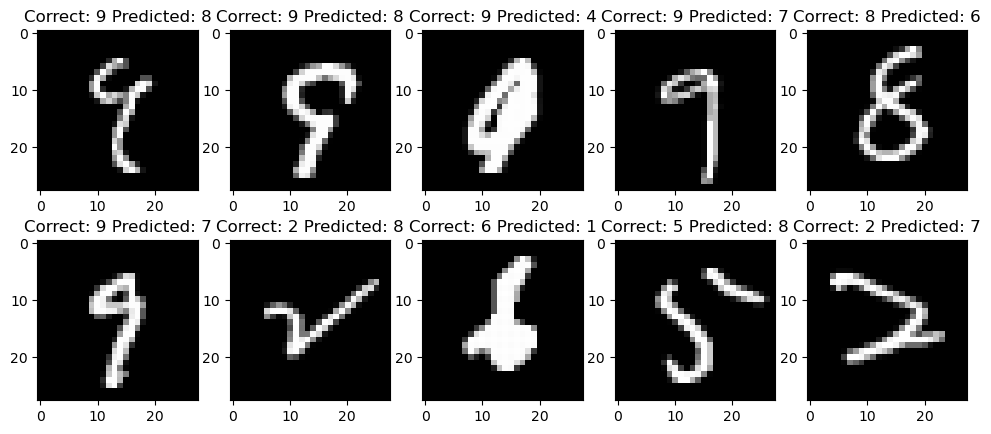

In [89]:
incorrect_pred = []
for i in range(len(y_test)):
    if np.argmax(y_test[i]) != np.argmax(predictions[i]):
        incorrect_pred.append((i,np.argmax(y_test[i]),np.argmax(predictions[i])))

fig, axs = plt.subplots(2,5, figsize=(12,5))

for i in range(10):
    if i < 5:
        axs[0 , i].imshow(x_test[incorrect_pred[i][0]].reshape((28,28)), cmap="gray")
        axs[0 , i].set_title(f'Correct: {incorrect_pred[i][1]} Predicted: {incorrect_pred[i][2]}')
    else:
        axs[1 , i - 5].imshow(x_test[incorrect_pred[i][0]].reshape((28,28)), cmap="gray")
        axs[1 , i - 5].set_title(f'Correct: {incorrect_pred[i][1]} Predicted: {incorrect_pred[i][2]}')


## Conclusion

### Our model achieved high accuracy after only 5 epochs. Although we have high accuracy, there are still some erroneous results. The t-SNE cluster plot shows the relation between each class in the dataset and plots closely related class near each other. As seen in the graph, there are jumpers which indicates some of our data has very similar features. If we see some of the digits the model got wrong, we can see that the features are either not very clear or they are very similar to features of other classes. In my opinion some of those images are not even clear to the human eye, so the model did really well.